In [1]:
import torch

from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from collidium import *

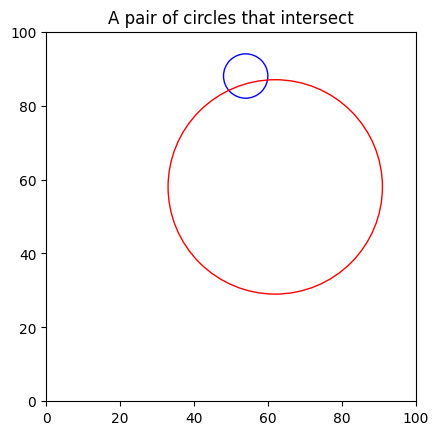

In [2]:
circles_proximity_queries_dataset_generator(8000, 0.5, 'train_proximity_queries.csv')
circles_proximity_queries_dataset_generator(2000, 0.5, 'test_proximity_queries.csv')
proximity_query_random_figure_generator('train_proximity_queries.csv')

In [3]:
training_data = ProximityQueriesDataset('train_proximity_queries.csv')
test_data = ProximityQueriesDataset('test_proximity_queries.csv')
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [4]:
learning_rate = 1e-3
weight_decay = 1e-5
batch_size = 64
epochs = 10
model = ShallowNetProximityQueries(input_size=6, hidden_size=32, output_size=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss, total_acc = 0, 0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)
        logits = model(X)

        loss = loss_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        y_hat = (torch.sigmoid(logits) > 0.5).float()
        total_acc += (y_hat == y).sum().item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = total_acc / len(dataloader.dataset)

    print(f"Train Error: \n Avg Acc: {avg_acc * 100:.2g}%, Avg loss: {avg_loss:.2g} \n")

    return avg_loss, avg_acc

def test_loop(dataloader, model, loss_fn):
    model.eval()
    total_loss, total_acc = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            logits = model(X)

            loss = loss_fn(logits, y)
            total_loss += loss.item() * X.size(0)
            y_hat = (torch.sigmoid(logits) > 0.5).float()
            total_acc += (y_hat == y).sum().item()

        avg_loss = total_loss / len(dataloader.dataset)
        avg_acc = total_acc / len(dataloader.dataset)

    print(f"Test Error: \n Avg Acc: {avg_acc * 100:.2g}%, Avg loss: {avg_loss:.2g} \n")

    return avg_loss, avg_acc

Train Error: 
 Avg Acc: 75%, Avg loss: 1.5 

Test Error: 
 Avg Acc: 90%, Avg loss: 0.28 

Train Error: 
 Avg Acc: 91%, Avg loss: 0.26 

Test Error: 
 Avg Acc: 93%, Avg loss: 0.21 

Train Error: 
 Avg Acc: 93%, Avg loss: 0.21 

Test Error: 
 Avg Acc: 95%, Avg loss: 0.18 

Train Error: 
 Avg Acc: 94%, Avg loss: 0.18 

Test Error: 
 Avg Acc: 95%, Avg loss: 0.16 

Train Error: 
 Avg Acc: 95%, Avg loss: 0.16 

Test Error: 
 Avg Acc: 96%, Avg loss: 0.14 

Train Error: 
 Avg Acc: 95%, Avg loss: 0.14 

Test Error: 
 Avg Acc: 97%, Avg loss: 0.12 

Train Error: 
 Avg Acc: 96%, Avg loss: 0.13 

Test Error: 
 Avg Acc: 97%, Avg loss: 0.11 

Train Error: 
 Avg Acc: 96%, Avg loss: 0.12 

Test Error: 
 Avg Acc: 97%, Avg loss: 0.1 

Train Error: 
 Avg Acc: 97%, Avg loss: 0.11 

Test Error: 
 Avg Acc: 97%, Avg loss: 0.09 

Train Error: 
 Avg Acc: 97%, Avg loss: 0.1 

Test Error: 
 Avg Acc: 98%, Avg loss: 0.089 



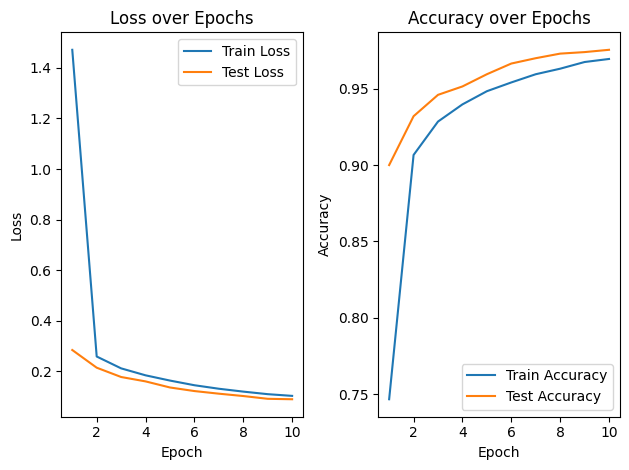

In [6]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []
epochs_range = range(1, epochs + 1)

for epoch in epochs_range:
    epoch_train_loss, epoch_train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    epoch_test_loss, epoch_test_acc = test_loop(test_dataloader, model, loss_fn)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig('proximity_queries_train_test_plot.png')

In [7]:
torch.save(model, 'proximity_queries_model.pth')